In [1]:
#%matplotlib notebook
from brian2 import *

taum = 20*ms
taue = 5*ms
taui = 10*ms
Vt = -50*mV
Vr = -60*mV
El = -49*mV

eqs = '''
dv/dt  = (ge+gi-(v-El))/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
dgi/dt = -gi/taui : volt
'''

P = NeuronGroup(4000, eqs, threshold='v>Vt', reset='v = Vr', refractory=5*ms,
                method='exact')
P.v = 'Vr + rand() * (Vt - Vr)'
P.ge = 0*mV
P.gi = 0*mV

we = (60*0.27/10)*mV # excitatory synaptic weight (voltage)
wi = (-20*4.5/10)*mV # inhibitory synaptic weight
Ce = Synapses(P, P, on_pre='ge += we')
Ci = Synapses(P, P, on_pre='gi += wi')
Ce.connect('i<3200', p=0.02)
Ci.connect('i>=3200', p=0.02)

s_mon = SpikeMonitor(P)
v_mon = StateMonitor(P, 'v', record=[0, 1])

net = Network(P, Ce, Ci, s_mon, v_mon)

net.run(1 * second)

plot(s_mon.t/ms, s_mon.i, ',k')
xlabel('Time (ms)')
ylabel('Neuron index')
figure()
plot(v_mon.t/ms, v_mon.v.T/mV)

In [1]:
from brian2 import *

G1 = NeuronGroup(10, 'dv/dt = -v / (10*ms) : 1',
                 threshold='v > 1', reset='v=0.', method='exact')
G1.v = 1.2
G2 = NeuronGroup(10, 'dv/dt = -v / (10*ms) : 1',
                 threshold='v > 1', reset='v=0', method='exact')

syn = Synapses(G1, G2, 'dw/dt = -w / (50*ms): 1 (event-driven)', on_pre='v += w')
print(syn.equations)
syn.connect('i == j', p=0.75)

# Set the delays
syn.delay = '1*ms + i*ms + 0.25*ms * randn()'
# Set the initial values of the synaptic variable
syn.w = 1

mon = StateMonitor(G2, 'v', record=True)


net2 = Network(syn, G1, G2, mon)
net2.run(20*ms)

# plot(mon.t/ms, mon.v.T)
# xlabel('Time (ms)')
# ylabel('v')



In [52]:
import sympy
a = syn._pathways[0].abstract_code
l = a.split('\n')
l = [x.split('=') for x in l[:-1]] # exclude last element in l, because using split on '\n', the last element in list in empty string

In [46]:
k = '='.join(l[0])
k
sympy.latex(str_to_sympy(a))

'_w = 1.0*w*exp(-0.02*(t - lastupdate)/ms)'

In [48]:
[[print(i) for i in x]   for x in l]

_w 
 1.0*w*exp(-0.02*(t - lastupdate)/ms)
w 
 _w
v +
 w
lastupdate 
 t


[[None, None], [None, None], [None, None], [None, None]]

In [15]:
syn.event_driven

dw/dt = -0.02*w/ms : radian (event-driven)


In [25]:
G1.equations

dv/dt = -0.1*v/ms : radian


In [24]:
print(G1.equations)

dv/dt = -v / (10*ms) : 1


In [2]:
import re
import sympy
import os.path
import subprocess
from graphviz import Digraph
from brian2tools import brian_plot
from matplotlib import pyplot as pp
from brian2.parsing.sympytools import str_to_sympy

In [3]:
def generate_ng_latex(NG):
    '''
    NG: NeuronGroup
    
    generate a string containing latex format presentation of input NeuronGroup
    '''
    NG_name =   '\\texttt{'+  NG.name.replace('_','\\_') + '}'
    text = ['\n', r'NeuronGroup "%s" with %d neurons.\\\\' % (NG_name, NG._N)]
    text.append(r'\textbf{Model:} \\ ')
    text.append(sympy.latex(NG.equations))

    def add_event_to_text(event):
        if event=='spike':
            event_header = 'Spiking behaviour'
            event_condition = 'Threshold condition'
            event_code = 'Reset statement(s)'
        else:
            event_header = 'Event "%s"' % event
            event_condition = 'Event condition'
            event_code = 'Executed statement(s)'
        condition = NG.events[event]
        text.append('\\\\\\\\ \\textbf{%s:}\n\\begin{itemize}' % event_header)
        text.append(r'\item \textit{%s:}' % event_condition)
        text.append(sympy.latex(str(condition)))
        statements = NG.event_codes.get(event, None)
        if statements is not None:
            text.append(r'\item \textit{%s:}' % event_code)
            #if '\n' in str(statements):
             #   text.append('\\')
            text.append(sympy.latex(str(statements)))
        text.append('\end{itemize}')

    if 'spike' in NG.events:
        add_event_to_text('spike')
    for event in NG.events:
        if event!='spike':
            add_event_to_text(event)
    text.append('\\pagebreak\n')

    return '\n'.join(text)
        

In [4]:
def generate_network_graph(net):
    '''
    net: Network object in brian2
    
    generate a network graph
    '''
    g = Digraph('G', filename='synapse.gv')

    g.attr('node', shape='doublecircle')

    #print collect()
    for obj in net.objects:
        g.attr('node', shape='doublecircle')
        #print(obj.name, obj.__class__.__name__) 
        if obj.__class__ is Synapses:
            g.attr('node', shape='doublecircle')
            #print ('    from=%s to=%s'%(obj.source.name, obj.target.name) )
            g.edge(obj.source.name, obj.target.name, label='<<b><i>'+obj.name+'</i></b>>', nodesep='1',minlen='4' )
        if obj.__class__ is SpikeMonitor:
            g.attr('node', shape='diamond')
            g.edge(obj.name, obj.source.name)
        if obj.__class__ is StateMonitor:
            g.attr('node', shape='pentagon')
            g.edge(obj.name, obj.source.name)

    path = g.render('net', 'tmp', format='png' )
    
    return path

In [22]:
def generate_latex_synapse_on_pre(syn):
    str_on_pre = ''
    for x in syn._pathways:
        eq = re.compile('[+*-]?=')
        comment = re.compile('#.*')

        l = x.code.split('\n')
        l = [x for x in l if x] # remove empty string element in list
        l_eq = [eq.search(x).group() for x in l]
        l = [eq.split(x,1) if eq.search(x) else x for x in l ] # split on equal sign, plus equal etc.
        l_rh = [comment.sub('', x[-1]) for x in l] # remove comment
        l_lh = [x[0] for x in l]
        l_comment = [y.group() if y else '' for y in  [comment.search(x[-1]) for x in l]] #extract a comment list
        
        eq_latex = ''
        for i, _ in enumerate(l_lh):
            eq_latex += sympy.latex(str_to_sympy(l_lh[i])) + '&' + l_eq[i] + sympy.latex(str_to_sympy(l_rh[i])) + '\\text{' + l_comment[i] + '}'
        eq_latex = '\\begin{align}\n' + eq_latex + '\\end{align}\n'
        str_on_pre += eq_latex
        
        return str_on_pre

In [6]:
def write_syn_latex(file, syn):
    '''
    write the Synapses latex code into file.
    '''
    syn_name = '\\texttt{'+  syn.name.replace('_','\\_') + '}'
    file.write('\nSynapse ' + syn_name + ':\n')
    if syn.event_driven is not None:
        file.write(sympy.latex(syn.event_driven))
    if bool(syn.summed_updaters):
        for k in syn.summed_updaters:
            file.write(sympy.latex(syn.summed_updaters[k]))
    if len(syn.equations) != 0:
        file.write(sympy.latex(syn.equations))
    file.write(generate_latex_synapse_on_pre(syn))
    file.write('\n\\pagebreak\n')
    

In [7]:
def write_state_mon_latex(file, mon):
    '''
    write StateMonitor and SpikeMonitor group into file
    '''
    pic_path = 'tmp/' + mon.name + '.png'
    brian_plot(mon)
    pp.savefig(pic_path)

    mon_name = '\\texttt{'+  mon.name.replace('_','\\_') + '}'
    file.write('\n\nStateMonitor ' + mon_name + ':\\\\\n')

    file.write('\\includegraphics[width=\\textwidth]{'+ pic_path + '} \n\\pagebreak\n')
    

In [8]:
def write_spike_mon_latex(file, mon):
    '''
    write StateMonitor and SpikeMonitor group into file
    '''
    pic_path = 'tmp/' + mon.name + '.png'
    brian_plot(mon)
    pp.savefig(pic_path)

    mon_name = '\\texttt{'+  mon.name.replace('_','\\_') + '}'
    file.write('\n\nSpikeMonitor ' + mon_name + ':\\\\\n')

    file.write('\\includegraphics[width=\\textwidth]{'+ pic_path + '} \n\\pagebreak\n')
    

In [9]:
def generate_tex_file(net,outputFile):
    
    file = open(outputFile,'w')
    fileHead = '\\documentclass[10pt]{article}\n\\usepackage{amsmath}\n\\usepackage{graphicx}\n\\usepackage[T1]{fontenc}\n\\begin{document}'
    fileEnd = '\n\\end{document}'
    
    #network graph----------------
    net_graph_path = generate_network_graph(net)
    net_graph_latex_path = net_graph_path.replace('\\','/')
    net_graph_text = '\n\n\\includegraphics[width=\\textwidth]{'+ net_graph_latex_path + '} \n\\pagebreak\n'
    #----------------------------
    
    file.write(fileHead)
    file.write(net_graph_text)
    
    #latex----------------
    for obj in net.objects:
        if obj.__class__ is NeuronGroup:
            file.write(generate_ng_latex(obj))
        if obj.__class__ is Synapses:
            write_syn_latex(file, obj)
        if obj.__class__ is StateMonitor:
            write_state_mon_latex(file, obj)
        if obj.__class__ is SpikeMonitor:
            write_spike_mon_latex(file, obj)
    #-----------------------------
    
    file.write(fileEnd)
    file.close()

In [10]:
def create_pdf(input_filename, output_filename):
    process = subprocess.Popen([
        'latex',   # Or maybe 'C:\\Program Files\\MikTex\\miktex\\bin\\latex.exe
        '-output-format=pdf',
        '-job-name=' + output_filename,
        input_filename])
    process.wait()

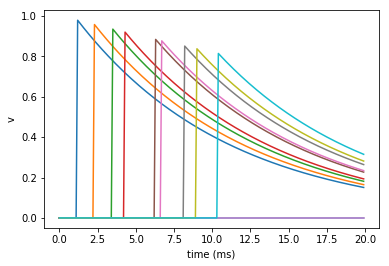

In [23]:
# generate_tex_file(net,'tmp/net.tex')
# create_pdf('tmp/net.tex','pdf/net')
generate_tex_file(net2,'tmp/net2.tex')
create_pdf('tmp/net2.tex','pdf/net2')